## 1. Generative Adversarial Networks



Generative Adversarial Networks (GANs) are powerful machine learning models capable of generating realistic image, video, and voice outputs. Two models are trained simultaneously by an adversarial process. A generator ("the artist") learns to create images that look real, while a discriminator ("the art critic") learns to tell real images apart from fakes.

![alt text](https://www.tensorflow.org/tutorials/generative/images/gan1.png)

During training, the generator progressively becomes better at creating images that look real, while the discriminator becomes better at telling them apart. The process reaches equilibrium when the discriminator can no longer distinguish real images from fakes.

![alt text](https://www.tensorflow.org/tutorials/generative/images/gan2.png)

# Data

Using downloaded and verified file: data/train_32x32.mat


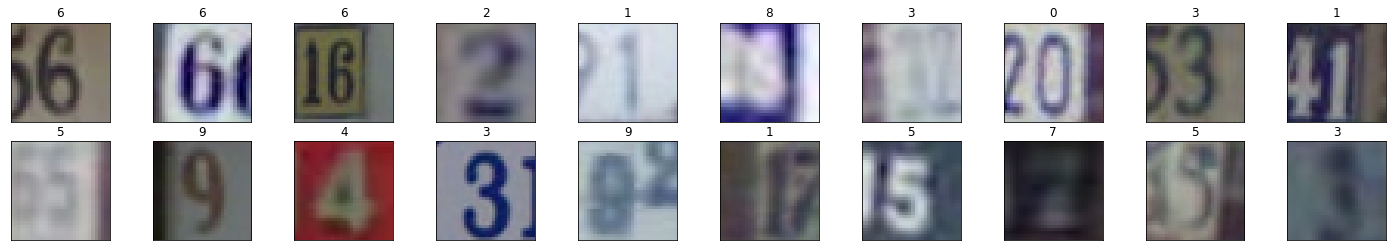

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl


import torch
from torchvision import datasets
from torchvision import transforms

# Tensor transform
transform = transforms.ToTensor()

# SVHN training datasets
svhn_train = datasets.SVHN(root='data/', split='train', download=True, transform=transform)

batch_size = 128
num_workers = 0

# build DataLoaders for SVHN dataset
train_loader = torch.utils.data.DataLoader(dataset=svhn_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers)


# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.transpose(images[idx], (1, 2, 0)))
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))


# current range
img = images[0]


**Scale image**

In [31]:
print('Min: ', img.min())
print('Max: ', img.max())

# helper scale function
def scale(x, feature_range=(-1, 1)):
    ''' Scale takes in an image x and returns that image, scaled
       with a feature_range of pixel values from -1 to 1. 
       This function assumes that the input x is already scaled from 0-1.'''
    # assume x is scaled to (0, 1)
    # scale to feature_range and return scaled x
    min, max = feature_range
    x = x * (max - min) + min
    return x


# scaled range
scaled_img = scale(img)

print('Scaled min: ', scaled_img.min())
print('Scaled max: ', scaled_img.max())


Min:  tensor(0.1098)
Max:  tensor(0.5529)
Scaled min:  tensor(-0.7804)
Scaled max:  tensor(0.1059)


# Discriminator

In [32]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, 
                           kernel_size, stride, padding, bias=False)
    # append conv layer
    layers.append(conv_layer)
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
    # using Sequential container return the layers
    return nn.Sequential(*layers)


class Discriminator(nn.Module):

    def __init__(self, conv_dim=32):
        super(Discriminator, self).__init__()

        # complete init function
        self.conv_dim = conv_dim

        # 32x32 input
        # input 3 out conv_dim , kernel = 4 (1 line)
        self.conv1 = conv(3, conv_dim, 4)

        # 16x16 out
        # input  conv_dim outpus conv_dim * 2 , kernel = 4 (1 line)
        self.conv2 = conv(conv_dim, conv_dim*2, 4)

        # 8x8 out
        # input  conv_dim * 2 outpus conv_dim * 4 , kernel = 4 (1 line)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

        # 4x4 out
        
        # final, fully-connected layer
        self.fc = nn.Linear(conv_dim*4*4*4, 1)

    def forward(self, x):
        # all hidden layers + leaky relu activation (3 lines)
        out = nn.LeakyReLU()(self.conv1(x))
        out = nn.LeakyReLU()(self.conv2(out))
        out = nn.LeakyReLU()(self.conv3(out))       
        
        # flatten
        out = out.view(-1, self.conv_dim*4*4*4)
        
        # final output layer
        out = self.fc(out)  
        return out

# Generator

In [33]:
# helper deconv function
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transposed-convolutional layer, with optional batch normalization.
    """
    # create a sequence of transpose + optional batch norm layers
    layers = []
    transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, 
                                              kernel_size, stride, padding, bias=False)
    # append transpose convolutional layer
    layers.append(transpose_conv_layer)
    
    if batch_norm:
        # append batchnorm layer
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)


class Generator(nn.Module):
    
    def __init__(self, z_size, conv_dim=32):
        super(Generator, self).__init__()

        # complete init function
        
        self.conv_dim = conv_dim
        
        # first, fully-connected layer
        self.fc = nn.Linear(z_size, conv_dim*4*4*4)

        # transpose conv layers
        # create deconv layer input conv_dim * 4 output conv_dim*2
        # create deconv layer input conv_dim * 2 output conv_dim 
        # create deconv layer input conv_dim  output 3
        # 3 lines
        self.deconv1 = deconv(conv_dim*4, conv_dim*2,4)
        self.deconv2 = deconv(conv_dim*2, conv_dim,4)
        self.deconv3 = deconv(conv_dim, 3,4)
        

    def forward(self, x):
        # fully-connected + reshape 
        # Call fc Layer (1 line)
        out = self.fc(x)
        out = out.view(-1, self.conv_dim*4, 4, 4) # (batch_size, depth, 4, 4)
        
        # 2 hidden transpose conv layers + relu (2 lines)
        out = nn.ReLU()(self.deconv1(out))
        out = nn.ReLU()(self.deconv2(out))
        
        # last layer deconv  + tanh activation
        out = nn.Tanh()(self.deconv3(out))
        
        return out

# Training

In [34]:
import torch.optim as optim
import pickle as pkl

# define params
conv_dim = 32
z_size = 100

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D)
print()
print(G)

train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    # move models to GPU
    G.cuda()
    D.cuda()
    print('GPU available for training. Models moved to GPU')
else:
    print('Training on CPU.')
    
# hyperparams
lr = 0.0002
beta1=0.5
beta2=0.999 # default value
num_epochs = 50

# Create optimizers for the discriminator and generator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

# keep track of loss and generated, "fake" samples
samples = []
losses = []

print_every = 300
sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
fixed_z = torch.from_numpy(fixed_z).float()

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(

# Losses

In [35]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # smooth, real labels = 0.9
        labels = torch.ones(batch_size)*0.9
    else:
        labels = torch.ones(batch_size) # real labels = 1
    # move labels to GPU if available     
    if train_on_gpu:
        labels = labels.cuda()
    # binary cross entropy with logits loss
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    if train_on_gpu:
        labels = labels.cuda()
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

Epoch [    1/   50] | d_loss: 0.0000 | g_loss: 14.7891
Epoch [    1/   50] | d_loss: 0.8285 | g_loss: 0.9249
Epoch [    2/   50] | d_loss: 0.3711 | g_loss: 2.2947
Epoch [    2/   50] | d_loss: 0.5599 | g_loss: 1.8066
Epoch [    3/   50] | d_loss: 0.5179 | g_loss: 2.6936
Epoch [    3/   50] | d_loss: 0.2320 | g_loss: 3.7852
Epoch [    4/   50] | d_loss: 0.9947 | g_loss: 3.3700
Epoch [    4/   50] | d_loss: 0.4719 | g_loss: 1.6328
Epoch [    5/   50] | d_loss: 0.3886 | g_loss: 2.6707
Epoch [    5/   50] | d_loss: 0.4109 | g_loss: 1.9542
Epoch [    6/   50] | d_loss: 0.9043 | g_loss: 4.1618
Epoch [    6/   50] | d_loss: 0.2719 | g_loss: 3.0742
Epoch [    7/   50] | d_loss: 0.3432 | g_loss: 4.1003
Epoch [    7/   50] | d_loss: 0.2008 | g_loss: 3.1970
Epoch [    8/   50] | d_loss: 0.8889 | g_loss: 4.8297
Epoch [    8/   50] | d_loss: 0.2469 | g_loss: 3.4979
Epoch [    9/   50] | d_loss: 0.5170 | g_loss: 4.1069
Epoch [    9/   50] | d_loss: 0.2358 | g_loss: 2.6382
Epoch [   10/   50] | d_los

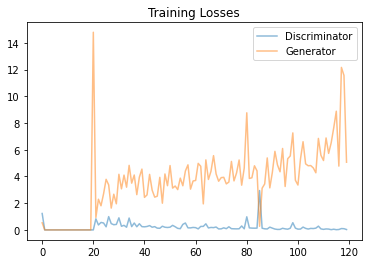

In [38]:
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        # Rescale images ( 1 line)
        real_images = scale(real_images)
        real_images = real_images.cuda()
        #print(real_images.shape)
        
        #  ---------- TRAIN THE DISCRIMINATOR ---------------
         
        d_optimizer.zero_grad()
        # 1. Train with real images
        D_out_real = D(real_images)
        # Compute the discriminator losses on real images 
        d_real_loss = real_loss(D_out_real)
       
        # 2. Train with fake images

        # Generate fake images with generator
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        z = z.cuda()

        fake_images = G(z)
        fake_images = fake_images.cuda()
        D_out_fake = D(fake_images)
            
        # Compute the discriminator losses on fake images
        d_fake_loss = fake_loss(D_out_fake)            
        # add up loss and perform backprop
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
         
        
        # ---------  TRAIN THE GENERATOR -----------

        g_optimizer.zero_grad()
        
        # 1. Train with fake images and flipped labels
        # Generate fake images
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        if train_on_gpu:
            z = z.cuda()
        fake_images = G(z)
        
        # Compute the discriminator losses on fake images 
        # using flipped labels! (2 lines)
        G_out_fake = D(fake_images)
        g_loss = real_loss(G_out_fake)
  
        # perform backprop
        g_loss.backward()
        g_optimizer.step()

        # Print some loss stats
        if batch_i % print_every == 0:
            # append discriminator loss and generator loss
            losses.append((d_loss.item(), g_loss.item()))
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    ## AFTER EACH EPOCH ##    
    # generate and save sample, fake images
    G.eval() # for generating samples
    if train_on_gpu:
        fixed_z = fixed_z.cuda()
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # back to training mode


# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)


fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()


# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

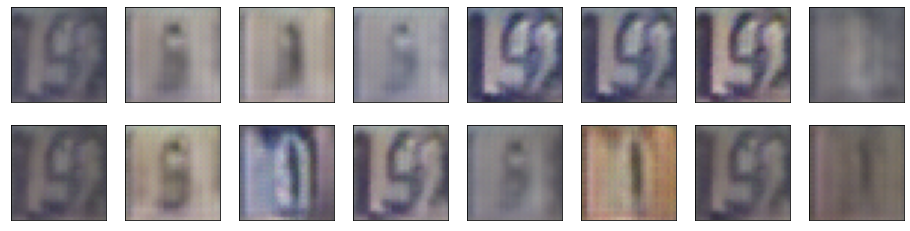

In [39]:
_ = view_samples(-1, samples)

Keep in mind:

1. Always use a lr for discriminator higher than the generator.

2. Keep training even if you see that the losses are going up.

3. There are many variations with different loss functions which are worth exploring.

4. If you get mode collapse, lower the learning rates.

5. Adding noise to the training data helps make the model more stable.

6. Label Smoothing: instead of making the labels as 1 make it 0.9 .


## References
1. [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)

2. [Intuitively Understanding Variational Autoencoders](https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf)

3. [Tutorial - What is a variational autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)

4. [The variational auto-encoder](https://ermongroup.github.io/cs228-notes/extras/vae/)

5. [An Introduction to Variational Autoencoders](https://arxiv.org/abs/1906.02691)

6. [Basic VAE Example](https://github.com/pytorch/examples/tree/master/vae)

7. [Deep Convolutional Generative Adversarial Network](https://www.tensorflow.org/tutorials/generative/dcgan)

8. [Generative adversarial networks: What GANs are and how they’ve evolved](https://venturebeat.com/2019/12/26/gan-generative-adversarial-network-explainer-ai-machine-learning/)

9. [Generative Adversarial Nets](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)

10. [GANs by google](https://developers.google.com/machine-learning/gan)

11. [A Gentle Introduction to Generative Adversarial Networks (GANs)](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/)

12. [A Beginner's Guide to Generative Adversarial Networks (GANs)](https://pathmind.com/wiki/generative-adversarial-network-gan)

13. [Understanding Generative Adversarial Networks (GANs)](https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29)

14. [Deep Learning (PyTorch)](https://github.com/udacity/deep-learning-v2-pytorch)

15. [10 Lessons I Learned Training GANs for one Year](https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628)